In [1]:
import numpy as np
import scipy as sp
import scipy.fftpack
from matplotlib import pyplot as plt
import scipy.io
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Image Processing/lez1_orth_basis')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Image Processing/lez1_orth_basis'

Generating 1-D DCT basis
------------------------


In [4]:
from numpy.ma.core import cos
import math
M = 128 # signal dimension
N = M # nr of atoms in the basis (this will be different when using redundant set of generators)

D = np.zeros((M, N)) # matrix containing the DCT basis (a DCT function in each column)
DCT = np.zeros((M, N)) # matrix containing the standard basis (a kronecker delta in each column)

for k in range(M):
    # take the formula from slides and remember to normalize. Each atom goes in a column of DCT matrix
    c = math.sqrt(1/M) if k == 0 else math.sqrt(2/M)
    n = np.arange(N)
    pi = math.pi
    DCT[:, k] = c * cos(k * pi * ((2 * n + 1) / (2 * M)))


Display an atom of the dct basis

Text(0.5, 1.0, 'element: 35 from the DCT basis')

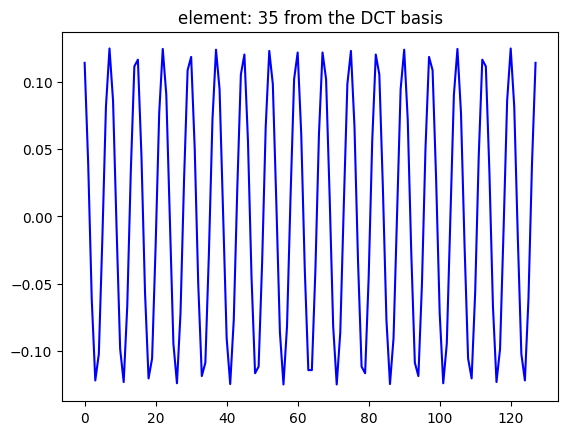

In [5]:
k = 34
plt.figure()
plt.plot(DCT[:, k], 'b')
plt.title(f'element: {k+1} from the DCT basis')

Check orthogonality

In [6]:
is_DCT_orth = np.allclose(np.dot(np.transpose(DCT) , DCT), np.identity(M))
print(f'DCT dictionary is orthogonal: {is_DCT_orth}')
MSE = ((np.dot(np.transpose(DCT) , DCT) - np.identity(M))**2).mean()
print(f'MSE: {MSE}')

DCT dictionary is orthogonal: True
MSE: 1.3638562448022797e-30


Display the basis in the matrix

Text(0.5, 1.0, 'DCT basis, atoms in the column')

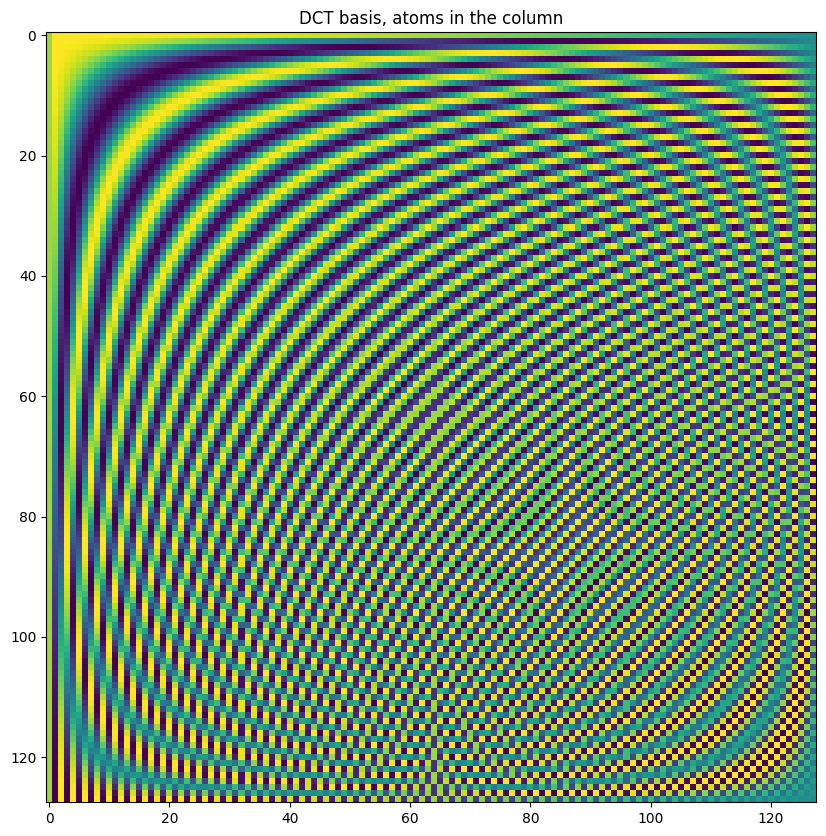

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')

Generate 1D DCT basis using the function idct 
---------------------------------------------
idct is the inverse dct transform stack this in the matrix D

In [8]:
for k in range(M):
    # define the atom
    a = np.zeros(M)
    a[k] = 1
    D[:, k] = sp.fftpack.idct(a, norm='ortho')


Display the basis in the matrix

Text(0.5, 1.0, 'DCT basis, atoms in the column')

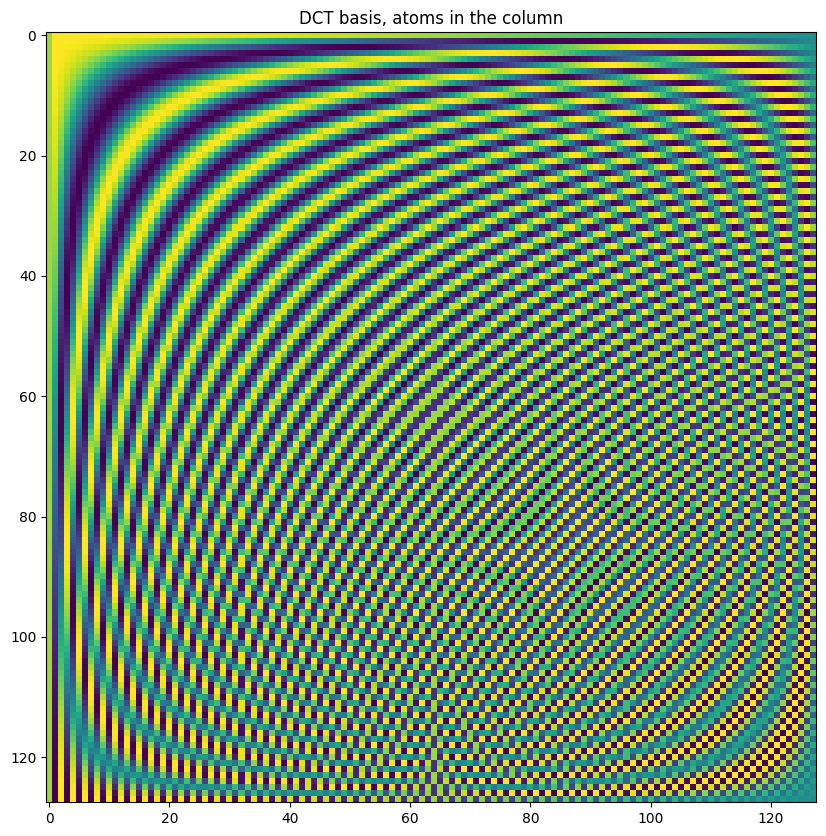

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')

Check that D and DCT defined above coincide

In [10]:
is_DCT_equal_D = np.allclose(DCT, D)
print(f'D and DCT are equal: {is_DCT_equal_D}')
MSE = ((DCT - D)**2).mean()
print(f'MSE: {MSE}')

D and DCT are equal: True
MSE: 8.791515790349376e-31


Analysis: compute the representation of an input ECG signal
-----------------------------------------------------------
Load few ECG signals to be processed

In [11]:
temp = scipy.io.loadmat(f'./data/croppedECG.mat')
nBeats = 10
S = temp['S'][:, :nBeats]
coeffD = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D

Compute the representation coefficients

In [12]:
for i in range(nBeats):
    coeffD[:, i] = np.dot(np.transpose(DCT), S[:,i])

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

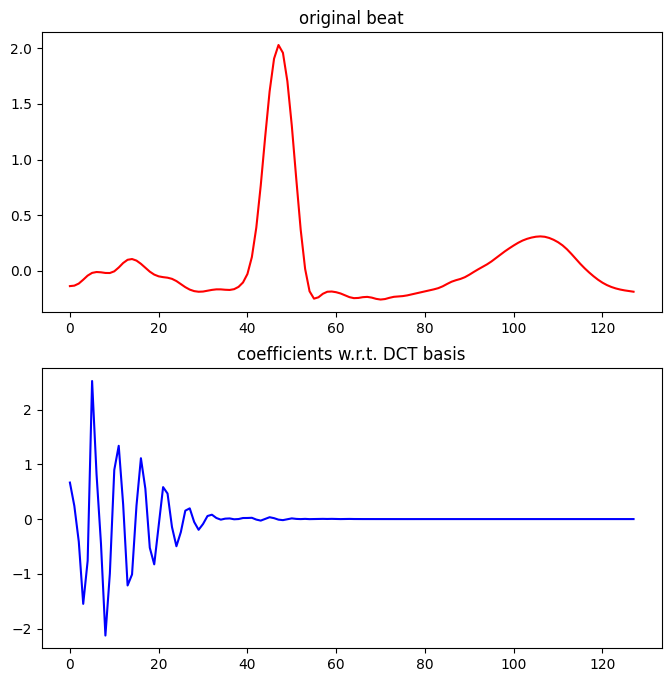

In [13]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(coeffD[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')

Synthesis: reconstruct all the ECG signals from their representations
---------------------------------------------------------------------
Reconstruct the two signals (express them w.r.t. the standard basis)

In [14]:
S_hat_D = np.dot(DCT, coeffD)


Check if there is perfect reconstruction.

It is trivial because $\hat S_D = DD^TS$ and $DD^T = I_M$  since $D$ is orthonormal (the same applies to $C$)

In [15]:
is_reconstruction_perfect = np.allclose(S, S_hat_D)
print(f'The reconstruction is perfect: {is_reconstruction_perfect}')
MSE = ((S - S_hat_D)**2).mean()
print(f'MSE: {MSE}')

The reconstruction is perfect: True
MSE: 6.0657104694591825e-30


Add noise to ECG data and inspect the representations
-----------------------------------------------------


In [16]:
sigma_noise = 0.1
S0 = S.copy()
S = S0 + sigma_noise * np.random.normal(size=S0.shape)

coeffD = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D


Compute the representation coefficients

In [17]:
for i in range(nBeats):
    coeffD[:, i] = np.dot(np.transpose(DCT), S[:,i])

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

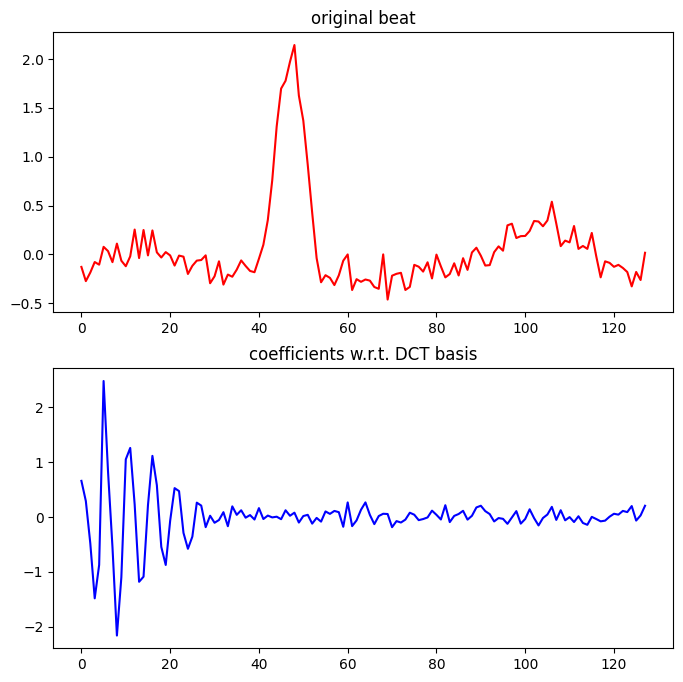

In [18]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(coeffD[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')

Hard Thresholding
-----------------
Noise affects all the coefficients of our transformation

Keep only few coefficients having largest magnitude

In [19]:
coeff_HT = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D
S_hat = np.zeros((M, nBeats))
L = 50 # sparsity level (try different values)

for i in range(nBeats):
    origSignal = temp['S'][:,i]
    noisySignal = origSignal + sigma_noise * np.random.normal(size=origSignal.shape)

    # transform each signal separately (analysis)
    coeff = np.dot(np.transpose(DCT), origSignal)

    # keep only the L largest coefficients (absolute value)
    #[...]
    coeff_HT[:, i] = coeff.copy()
    position_largest_values = np.argsort(-np.abs(coeff_HT[:, i]))[:L]

    for c in range(coeff_HT[:, i].shape[0]):
      if (c in position_largest_values) == False:
        coeff_HT[c, i] = 0

    # invert the transformation
    s_hat = np.dot(DCT, coeff_HT[:, i])

    S_hat[:, i] = s_hat
    

Display a signal

Text(0.5, 1.0, 'DCT coefficients')

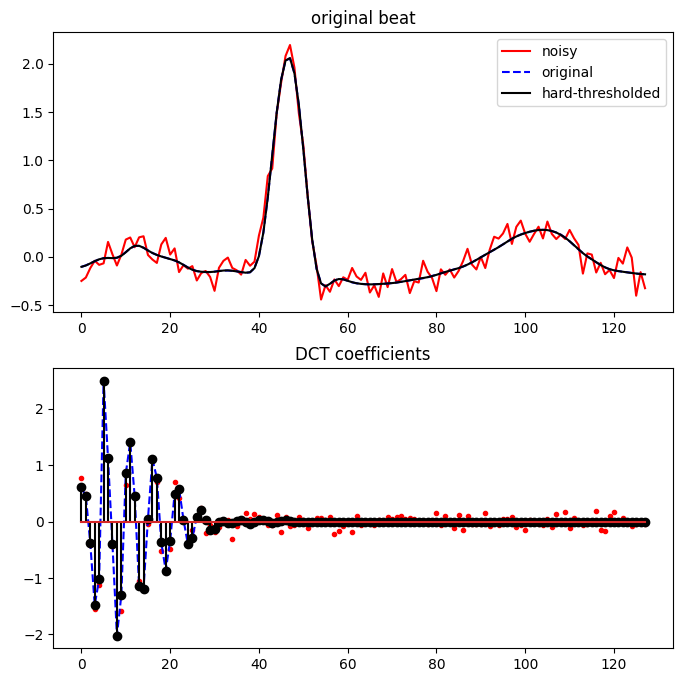

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'r')
ax1.plot(S0[:, i], 'b--')
ax1.plot(S_hat[:, i], 'k')
ax1.legend(['noisy', 'original', 'hard-thresholded'])
ax1.set_title('original beat')

# coefficients of the noisy signal
ax2.plot(np.matmul(D.T, S[:, i]), 'r.')
# coefficients of the noise free signal
ax2.plot(np.matmul(D.T, S0[:, i]), 'b--')
ax2.stem(np.arange(M), coeff_HT[:, i], 'k')
ax2.set_title('DCT coefficients')

Compression
-----------
Try to compress a heartbeat using different value of $L$ and plot the mean squared error corresponding to each $L$

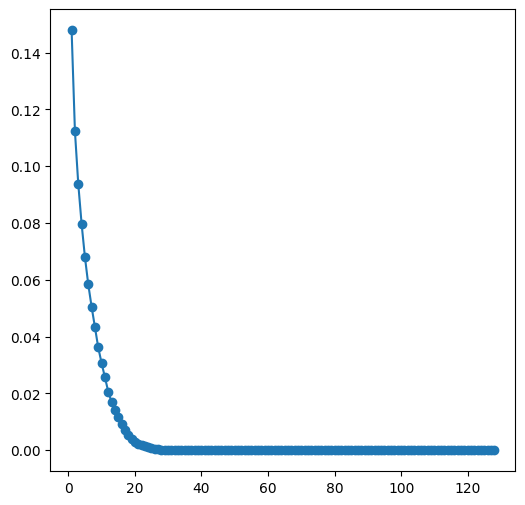

In [21]:
coeff_HT = np.zeros((M)) # initialize the matrix of representations of S w.r.t. D
S_hat = np.zeros((M))

L_values = np.arange(1, M+1)
MSE_values = np.zeros(M)

origSignal = temp['S'][:,0]

for L in L_values:
     # transform each signal separately (analysis)
    coeff = np.dot(np.transpose(DCT), origSignal)

    # keep only the L largest coefficients (absolute value)
    #[...]
    coeff_HT = coeff.copy()
    position_largest_values = np.argsort(-np.abs(coeff_HT))[:L]

    for c in range(coeff_HT.shape[0]):
      if (c in position_largest_values) == False:
        coeff_HT[c] = 0

    # invert the transformation
    s_hat = np.dot(DCT, coeff_HT)

    mse = ((origSignal - s_hat)**2).mean()

    MSE_values[L-1] = mse

plt.figure(figsize=(6,6))
plt.plot(L_values, MSE_values, '-o')